In [1]:
import sys
sys.path.insert(0, '/home/jianx/search-exposure/')
from train import train
from load_data import load
from gpu_allocator import select_device
from gpu_allocator import cleanup_gpu_list
import torch
import csv
from test import test
from test import test_loader
from test import get_ndcg_precision_rr
import random
from train import generate_sparse
from torch import optim

In [2]:
num_epochs = 2
epoch_size = 2
batch_size = 10
learning_rate = 0.01
embed_size = 64

print("Num of epochs:", num_epochs)
print("Epoch size:", epoch_size)
print("Batch size:", batch_size)
print("Learning rate:", learning_rate)
print("Embedding size:", embed_size)
rank = 10
test_batch =43
MODEL_PATH = "/home/jianx/data/results/"

Num of epochs: 2
Epoch size: 2
Batch size: 10
Learning rate: 0.01
Embedding size: 64


In [3]:
print("Loading data")
pos_neg_dict, query_dict, passage_dict, top_dict, rating_dict, query_test_dict = load()
print("Data successfully loaded.")
print("Positive Negative Pair dict size: " + str(len(pos_neg_dict)))
print("Num of queries: " + str(len(query_dict)))
print("Num of passages: " + str(len(passage_dict)))

Loading data
Data successfully loaded.
Positive Negative Pair dict size: 400782
Num of queries: 808731
Num of passages: 8841823


In [22]:
import torch
import torch.nn as nn

NUM_HIDDEN_NODES = 64
NUM_HIDDEN_LAYERS = 3
DROPOUT_RATE = 0.1
FEAT_COUNT = 100000


# Define the network
class DSSM(torch.nn.Module):

    def __init__(self, embed_size, device):
        super(DSSM, self).__init__()

        layers = []
        last_dim = FEAT_COUNT
        for i in range(NUM_HIDDEN_LAYERS):
            layers.append(nn.Linear(last_dim, NUM_HIDDEN_NODES))
            layers.append(nn.ReLU())
            layers.append(nn.LayerNorm(NUM_HIDDEN_NODES))
            layers.append(nn.Dropout(p=DROPOUT_RATE))
            last_dim = NUM_HIDDEN_NODES
        layers.append(nn.Linear(last_dim, embed_size))
        self.model = nn.Sequential(*layers)
        self.scale = torch.tensor([10], dtype=torch.float).to(device)
    def forward(self, x):
        embedding = nn.EmbeddingBag(FEAT_COUNT, FEAT_COUNT)
        x = embedding(x).sum(0)
        return self.model(x) * self.scale

    def parameter_count(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

VOCAB_LEN = 100000


def sparse_to_dense(idx, vocab_len=VOCAB_LEN):
    index_tensor = torch.LongTensor([idx])
    value_tensor = torch.Tensor([1] * len(idx))
    dense_tensor = torch.sparse.FloatTensor(index_tensor, value_tensor, torch.Size([vocab_len, ])).to_dense()
    return dense_tensor


def generate_sparse(idx, vocab_len=VOCAB_LEN):
    index_tensor = torch.LongTensor([idx])
    value_tensor = torch.Tensor([1] * len(idx))
    sparse_tensor = torch.sparse.FloatTensor(index_tensor, value_tensor, torch.Size([vocab_len, ]))
    return sparse_tensor


def mini_batch(batch_size, device, pos_neg_dict, query_dict, passage_dict):
    query_list = list(pos_neg_dict.keys())
    queries = []
    pos = []
    neg = []
    while len(queries) < batch_size:
        qid = random.sample(query_list, 1)[0]
        pos_neg_pair = random.sample(pos_neg_dict[qid], 1)
        pos_pid = pos_neg_pair[0][0]
        neg_pid = pos_neg_pair[0][1]
        q_seq = query_dict[qid]
        pos_seq = passage_dict[pos_pid]
        neg_seq = passage_dict[neg_pid]
        if q_seq != [] and pos_seq != [] and neg_seq != []:
            queries.append(torch.LongTensor(q_seq).to(device))
            pos.append(torch.LongTensor(pos_seq).to(device))
            neg.append(torch.LongTensor(neg_seq).to(device))
    labels = [0 for i in range(batch_size)]
    return queries, pos, neg, labels


def train(net, epoch_size, batch_size, optimizer, device, pos_neg_dict, query_dict,
          passage_dict):
    criterion = nn.CrossEntropyLoss()
    train_loss = 0.0
    net.train()
    for mb_idx in range(epoch_size):
        # Read in a new mini-batch of data!
        queries, pos, neg, labels = mini_batch(batch_size, device, pos_neg_dict, query_dict,
                                               passage_dict)
        optimizer.zero_grad()
        q_embed = net(queries)
        pos_embed = net(pos)
        neg_embed = net(neg)
        out_pos = torch.cosine_similarity(q_embed, pos_embed).unsqueeze(0).T
        out_neg = torch.cosine_similarity(q_embed, neg_embed).unsqueeze(0).T
        out = torch.cat((out_pos, out_neg), -1)
        loss = criterion(out, torch.tensor(labels).to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # print(str(mb_idx) + " iteration: " + str(train_loss / (mb_idx + 1)))
    return train_loss / epoch_size

In [6]:
CURRENT_DEVICE = torch.device("cuda:0")

In [13]:
net = DSSM(embed_size=embed_size, device=CURRENT_DEVICE).to(CURRENT_DEVICE)

In [24]:
for ep_idx in range(num_epochs):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    train_loss = train(net, epoch_size, batch_size, optimizer, CURRENT_DEVICE, pos_neg_dict,
                       query_dict, passage_dict)
    avg_ndcg, avg_prec, avg_rr = test(net, CURRENT_DEVICE, test_batch, top_dict, query_test_dict, passage_dict,
                                      rating_dict, rank)
    print("Epoch:{}, loss:{}, NDCG:{}, P:{}, RR:{}".format(ep_idx, train_loss, avg_ndcg, avg_prec, avg_rr))

AttributeError: 'list' object has no attribute 'dim'

In [34]:
embedding = nn.EmbeddingBag(10, 10, mode="sum", )
input = torch.LongTensor([[1,2,4,5], [0,1,9,8]])
embedding(input)

tensor([[-3.6896, -0.3273, -2.5080,  0.5653, -1.2815,  1.3265, -0.1262,  0.8897,
          0.5738,  0.3181],
        [-0.4931, -0.1923, -0.8758,  0.5458, -3.1003, -0.6314,  0.2613,  0.9411,
         -0.7424, -2.6701]], grad_fn=<EmbeddingBagBackward>)

In [28]:
tt = [torch.LongTensor([1,2]), torch.LongTensor([1,2,9,8])]
torch.stack(tt, dim = 0)

RuntimeError: stack expects each tensor to be equal size, but got [2] at entry 0 and [4] at entry 1

In [14]:
CURRENT_DEVICE = torch.device("cuda:3")
loaded_net = torch.load("/home/jianx/data/results/300_1500_100_0.01_256.model").to(CURRENT_DEVICE)

In [15]:
result_dict = test_loader(loaded_net, CURRENT_DEVICE, test_batch, top_dict, query_test_dict, passage_dict, rating_dict)
qids = list(result_dict.keys())

[(1056992, 0.9988421201705933), (742037, 0.9946508407592773), (2815189, 0.9936875700950623), (4945929, 0.9884414672851562), (2140502, 0.9838024377822876), (5245312, 0.977665901184082), (1768732, 0.9721917510032654), (5825120, 0.972136914730072), (3695908, 0.9699577689170837), (6148227, 0.9699546098709106), (4576122, 0.9673935174942017), (2617198, 0.966935396194458), (2244145, 0.9666087031364441), (3261114, 0.9616740942001343), (691288, 0.9606649875640869), (4016930, 0.955830991268158), (5072800, 0.9537691473960876), (7959720, 0.9487412571907043), (6828980, 0.9475806951522827), (4367833, 0.9419851899147034), (8105077, 0.9398841261863708), (4367830, 0.937769889831543), (3518297, 0.9308198094367981), (4422672, 0.9298780560493469), (1768733, 0.9290626645088196), (7670907, 0.928348183631897), (7857313, 0.9272759556770325), (1735869, 0.9264847040176392), (6059146, 0.9254395365715027), (5362609, 0.9252550005912781), (5486771, 0.9239426851272583), (4422671, 0.923937201499939), (995302, 0.92313

In [16]:
with open('/home/jianx/data/trec_eval/300_1500_100_0.01_256.teIn', 'w+') as f:
    for qid in qids:
        for rank, item in enumerate(sorted(result_dict[qid].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True)):
            f.write("{}\tQ0\t{}\t{}\t{}\trun-id\n".format(qid, item[0],rank+1, item[1]))

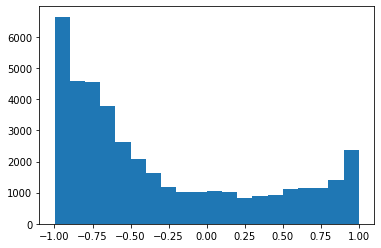

0.03413576336435846
0.09814336533307344


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
all_scores = []
num_95 = 0
num_neg95 = 0
for i in qids:
    for item in sorted(result_dict[i].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True):
        all_scores.append(item[1])
        if item[1] > 0.95:
            num_95+=1
        if item[1] < -0.95:
            num_neg95 += 1
plt.hist(all_scores, bins=20)
plt.show()
print(num_95/len(all_scores))
print(num_neg95/len(all_scores))

In [18]:
top_pids = []
qid = 1
for i in range(10):
    top_pids.append(sorted(result_dict[qids[qid]].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True)[i][0])
print(top_pids)

[3551618, 2009615, 4408691, 1863056, 83456, 555080, 6105784, 6895496, 3551621, 4827423]


(array([304., 191.,  60.,  51.,  47.,  33.,  37.,  44.,  59., 174.]),
 array([-9.97311234e-01, -7.97699982e-01, -5.98088729e-01, -3.98477477e-01,
        -1.98866224e-01,  7.45028257e-04,  2.00356281e-01,  3.99967533e-01,
         5.99578786e-01,  7.99190038e-01,  9.98801291e-01]),
 <a list of 10 Patch objects>)

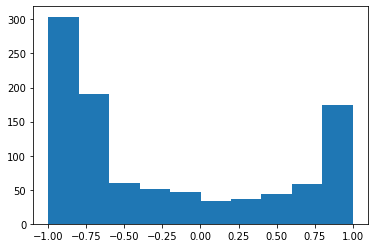

In [19]:
result0 = pd.DataFrame.from_dict(sorted(result_dict[qids[11]].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True))
plt.hist(result0[1])

In [20]:
import math
def get_ndcg_precision_rr(true_dict, test_dict, rank):
    sorted_result = sorted(test_dict.items(), key=lambda x: (x[1], [-1,1][random.randrange(2)]), reverse=True)
    original_rank = rank
    rank = min(rank, len(sorted_result))
    cumulative_gain = 0
    ideal_dict = true_dict
    num_positive = 0
    rr = float("NaN")
    for i in range(len(sorted_result)):
        pid = sorted_result[i][0]
        if pid in true_dict:
            rr = 1 / (i + 1)
            break
    for i in range(rank):
        pid = sorted_result[i][0]
        if pid in true_dict:
            num_positive += 1
    sorted_result = sorted(test_dict.items(), key=lambda x: x[1], reverse=True)
    for i in range(rank):
        pid = sorted_result[i][0]
        relevance = 0
        if pid in true_dict:
            relevance = true_dict[pid]
        ideal_dict[pid] = relevance
        discounted_gain = relevance / math.log2(2 + i)
        cumulative_gain += discounted_gain
    sorted_ideal = sorted(ideal_dict.items(), key=lambda x: x[1], reverse=True)
    ideal_gain = 0
    for i in range(rank):
        relevance = sorted_ideal[i][1]
        discounted_gain = relevance / math.log2(2 + i)
        ideal_gain += discounted_gain
    ndcg = 0
    if ideal_gain != 0:
         ndcg = cumulative_gain / ideal_gain
    return ndcg, num_positive / original_rank, rr
import numpy as np
result_ndcg = []
result_prec = []
result_rr = []
for qid in qids:
    if len(result_dict[qid]) < 10:
        print(qid)
    ndcg, prec, rr = get_ndcg_precision_rr(rating_dict[qid], result_dict[qid], 10)
    result_ndcg.append(ndcg)
    result_prec.append(prec)
    result_rr.append(rr)
print(result_ndcg)
avg_ndcg = np.nanmean(result_ndcg)
avg_prec = np.nanmean(result_prec)
avg_rr = np.nanmean(result_rr)
print(avg_ndcg,avg_prec,avg_rr)

855410
[0.0, 0.0, 0.6950477058805403, 0.031218489329128234, 0.1777898011244921, 0.02613275632622511, 0.034715610968388634, 0.0735874413409925, 0.0, 0.0636207881989517, 0.20778411473733654, 0.0, 0.0, 0.03668196104968002, 0.1454634185182333, 0.0, 0.0, 0.0767023408078252, 0.6325414799409711, 0.10529614491368275, 0.0, 0.10414512749449265, 0.0, 0.0, 0.22009176629808014, 0.0, 0.147053877022001, 0.14016605921614103, 0.1687615402048088, 0.0, 0.22009176629808017, 0.0, 0.13498882138167081, 0.0, 0.5067194034650795, 0.0, 0.8304503542647043, 0.02959618500861199, 0.28875014033780383, 0.206415932235089, 0.04269569655114159, 0.0, 0.05886610400269325]
0.12570639132364755 0.14883720930232555 0.31934597381525837


In [30]:
test_qid = 1133167
test_pid = 6112590
test_q_embed = net(generate_sparse(query_test_dict[test_qid]).to(CURRENT_DEVICE)).detach()
test_p_embed = net(generate_sparse(passage_dict[test_pid]).to(CURRENT_DEVICE)).detach()
test_score = torch.cosine_similarity(test_q_embed.unsqueeze(0), test_p_embed.unsqueeze(0)).item()
print(test_score)
print(test_p_embed)

print(test_q_embed)

-0.8975946307182312
tensor([-3.0296e+03, -5.2848e+04,  2.3425e-02,  6.3025e-02, -1.0471e-01,
        -1.2495e+03,  2.3125e+04,  6.2536e-02,  1.3906e-01,  2.3375e+04,
        -2.5828e+04,  4.8552e+02, -4.4572e+03, -2.1202e+04, -2.2999e-02,
         9.1718e-02, -4.9721e+04, -4.0220e+03,  3.5009e-01, -2.2760e+04,
        -1.8646e+04,  1.6650e+03, -4.0550e+04, -2.2024e+04,  5.0473e+04,
        -4.8476e+04,  1.4154e+04, -1.0826e+03, -6.3183e+03,  1.4134e-01,
        -8.9433e+03,  3.2223e+04, -9.0528e+03,  5.4107e+04,  4.3253e+04,
        -1.0032e+04, -9.7527e+03, -4.7771e+04,  2.5884e+04, -7.8262e+03,
         2.0455e-01,  5.1378e+04,  9.3307e+03,  6.5136e+03,  1.5810e+04,
         1.3519e-02, -1.0916e+04, -9.4892e+02,  4.7940e+03,  8.1336e+03,
        -3.5506e+04,  5.5301e+04, -2.1024e+04, -7.8287e+03,  2.0133e+04,
         5.7350e+03,  4.4025e+04,  2.8542e-02,  2.8935e+04,  2.3223e+04,
        -4.4460e+04, -1.4056e+04,  4.0348e+04,  8.1690e+03, -2.3161e-02,
         9.8422e+03,  7.1057e+0